In [9]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio


import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)

dpi = 300
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.ESPRIT_numpy import *

def RMS(x):
        return np.std(x)

figsize = (8.5/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

### Creating a basic modulated sine-wave

In [10]:
sr_hz = 22050
t = np.arange(2*sr_hz)
baseFreq = 440/sr_hz #Hz
modFreq = 1/sr_hz #Hz
modAmp = 100/sr_hz #Hz
sineAmp = 1
noiseAmp = .1

full_phase = baseFreq*t + modAmp/(2*np.pi*modFreq)*np.cos(2*np.pi*modFreq*t)
full_phase *= 2*np.pi
#x = sineAmp*np.sin(full_phase)
#x += noiseAmp*np.random.randn(np.shape(t)[0])


## Loading the audio file

In [11]:
fileName = os.path.join('..', 'Data', 'Test', '69.wav')
x, sr_hz = librosa.load(fileName)
x = x[:2*sr_hz]



# Preprocessing

In [12]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "preprocessing", "Figures")

## Sub-band decomposition

## Whitening the noise

In [14]:
rankFilter_bins = 21
rankFilter_rank = .3

window_length = 512
hop_length = window_length

c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


TypeError: Dimensions of C (257, 87) are incompatible with X (86) and/or Y (257); see help(pcolormesh)

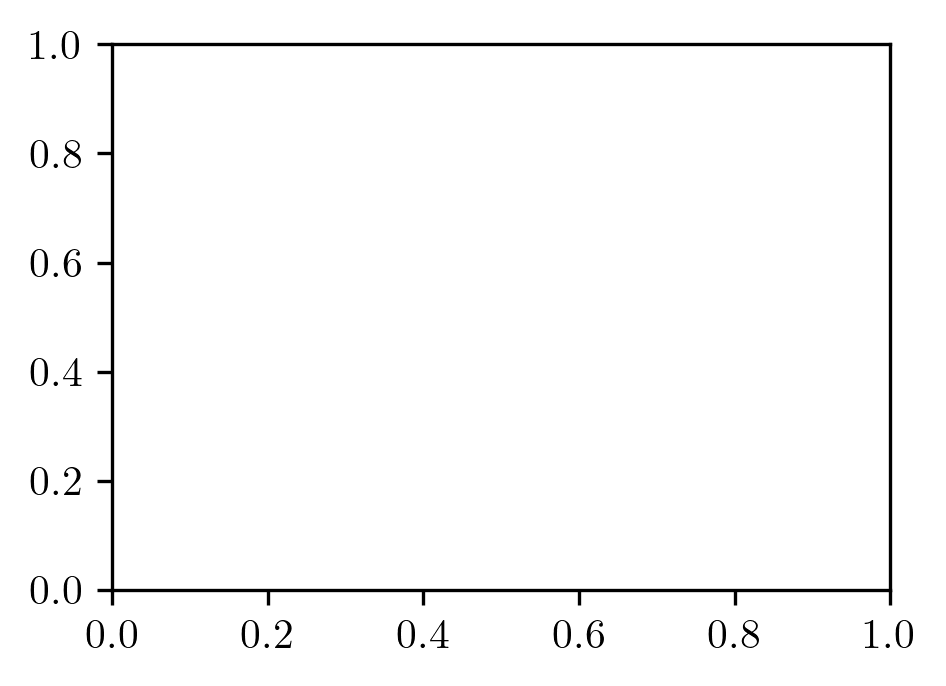

In [19]:
window_type = 'hann'
xWhitened, ARFilters = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)

xWhitenedWindowed = window_signal(
    x = xWhitened,
    window_length = window_length,
    hop_length = hop_length,
)
xWindowed = window_signal(
    x = x,
    window_length = window_length,
    hop_length = hop_length,
)
xWhitened_stft = compute_stft_from_windowed(xWhitenedWindowed, window_type=window_type)

cmap = 'gray'
dpi = 300

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "input_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
#plt.show()
plt.close()

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB10(xRankFiltered_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|N|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "noise_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
#plt.show()
plt.close()


plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(xWhitened_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = "$|X_{\mathrm{blanchi}}|^2$")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "whitened_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()


In [ ]:
time_frame_display = 11

plt.figure(figsize = figsize)
#plt.figure(figsize = (15, 5))
plt.plot(f_list, dB20(x_stft[:,time_frame_display]), 'k', linewidth = .5, label = '$|X|^2$')
plt.plot(f_list, dB10(xRankFiltered_stft[:,time_frame_display]), 'r--', linewidth = .5, label = "$|N|^2$")
plt.legend(ncols = 1)
plt.xlabel("$f$ [Hz]")
plt.ylabel("[dB]")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "spectre_bruit.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()

plt.figure(figsize = figsize)
#plt.figure(figsize = (15, 5))
plt.plot(f_list, dB20(x_stft[:,time_frame_display]), 'k', linewidth = .5, label = '$|X(f)|^2$')
plt.plot(f_list, dB20(1/np.fft.rfft(ARFilters[time_frame_display], n=window_length)/300), 'r--', linewidth = .5, label = "|H(f)|")
plt.legend(ncols = 1)
plt.xlabel("$f$ [Hz]")
plt.ylabel("[dB]")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "spectre_AR.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()

In [ ]:
time_frame_display = 11

plt.figure(figsize = figsize)
#plt.figure(figsize = (15, 5))
plt.plot(f_list, dB20(x_stft[:,time_frame_display]), 'b--', linewidth = .5, label = '$|X|^2$')
#plt.plot(f_list, dB10(xRankFiltered_stft[:,time_frame_display]), 'k--', linewidth = .5)
plt.plot(f_list, dB20(1/np.fft.rfft(ARFilters[time_frame_display], n=window_length)/300), 'r-.', linewidth = .5, label = "$|H|^2$")
plt.plot(f_list, dB20(xWhitened_stft[:,time_frame_display]), 'k-', linewidth = .5, label = "$|X_{\mathrm{blanchi}}|^2$")
plt.legend(ncols = 1)
plt.xlabel("$f$ [Hz]")
plt.ylabel("[dB]")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "blanchissement_spectre.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()

In [ ]:
num_poles = 32
time_frame_display = 11

poles, complexAmp, Lambda = ESPRIT(xChopped[time_frame_display], num_poles = num_poles)
freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]

plt.figure(figsize = figsize)
plt.plot(f_list, dB20(np.fft.rfft(xChopped[time_frame_display]*np.hanning(window_length))), 'k')
for f in freqs:
    plt.axvline(f,0,1, color = 'r', linestyle = '--')
plt.xlabel("$f$ [Hz]")
plt.ylabel("$|X|^2$ [dB]")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "ESPRIT_input.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()


poles, complexAmp, Lambda = ESPRIT(xWhitened[time_frame_display], num_poles = num_poles)
freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]

plt.figure(figsize = figsize)
plt.plot(f_list, dB20(np.fft.rfft(xWhitened[time_frame_display]*np.hanning(window_length))),'k')
for f in freqs:
    plt.axvline(f,0,1, color = 'r', linestyle = '--')
plt.xlabel("$f$ [Hz]")
plt.ylabel("$|X_{\mathrm{blanchi}}|^2$ [dB]")
plt.tight_layout()
plt.savefig(fname = os.path.join(save_folder, "ESPRIT_whitened.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()